In [1]:
#Import Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
import pymongo
import json
import re
import string
import nltk
import emoji
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [2]:
#Set up variables to access MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
# Database Name
database = client["collegedb"]
# Collection Name
collection = database["breakingNews"]

In [3]:
#Show connection
collection

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'collegedb'), 'breakingNews')

In [4]:
breakingNews = pd.DataFrame.from_records(list(collection.find()))

In [5]:
breakingNews['tweetDate']=pd.to_datetime(breakingNews['tweetcreatedts']).dt.date
breakingNews['tweetDate'] = breakingNews['tweetDate'].astype("datetime64[ns]")
print(breakingNews.isnull().sum())
print(breakingNews.info())
print(breakingNews.shape)
#breakingNews['tweetDate'].groupby(breakingNews["tweetDate"].dt.date).count().plot(kind="bar")

_id               0
text              0
tweetcreatedts    0
tweetDate         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946365 entries, 0 to 4946364
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   _id             object        
 1   text            object        
 2   tweetcreatedts  object        
 3   tweetDate       datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 151.0+ MB
None
(4946365, 4)


In [6]:
def remove_duplicates(sentence):
    words = sentence.split(" ")
    result = []
    for word in words:
        if word not in result:
            result.append(word)
    return " ".join(result)

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove urls
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove emojis
    text = (emoji.replace_emoji(text, ''))
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra chars
    text = re.sub(r"[^\w\s]+", "", text)
    # Remove Duplicates
    text = remove_duplicates(text)
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    # Lemmatize words
    lem = WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]
    # Remove stop words
    words = [word for word in words if word not in stpwrd]
    # Join words back into text
    text = ' '.join(words)
    return text

def count_words(s):
    return len(s.split())

In [7]:
breakingNews.shape

(4946365, 4)

In [8]:
sampleAmount = 0.01
breakingNewsSamp = breakingNews.groupby('tweetDate').apply(lambda x: x.sample(frac= sampleAmount ))

In [9]:
breakingNewsSamp.shape

(49471, 4)

In [10]:
#Add commonly seen words that are not info related.
new_stopwords = ["news", "ha", "u", "via", "amp", "link", "wa"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

breakingNewsSamp['clean_text'] = breakingNewsSamp['text'].apply(clean_text)
breakingNewsSamp['countWords'] = breakingNewsSamp['clean_text'].apply(count_words)
breakingNewsSamp = breakingNewsSamp[breakingNewsSamp['countWords']>5]
print(breakingNewsSamp.shape)

(41369, 6)


In [11]:
breakingNewsSamp.head(5)

_id                                                                                                                                                                                                                                       text       tweetcreatedts  tweetDate                                                                                                                             clean_text  countWords
tweetDate                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2022-08-02 2251681  644d2cfd1fed118138fca750  Crowds Flock to Steal Hash After Boat Carrying Contraband Crashes on Spanish Beach The unprecedented hash loot occurred during a drug bust that was led by the custom department of Spain. #LatestNews by #News18 https://t.co/EIySGDLIwt  2022-08-02 12:08:03 2022-08-02  crowd flock steal hash boat carrying contraband crash spanish beach unprecedented loot occurred drug bust led custom department spain          19
           2251723  644d2cfd1fed118138fca77a        Dominica Budget 2022/23 features plans for enhancement of Primary Health Care System\n\n#Dominica #PMSkerrit #BreakingNews #News #Caribbean #CaribbeanNews #LatestNews #BUdget #Heath #rooseveltskerrit \n\nhttps://t.co/MDCaU77OXj  2022-08-02 13:30:00 2022-08-02                                                             dominica budget 202223 feature plan enhancement primary health care system          10
           2251784  644d2cfd1fed118138fca7b7                                                              Latest: XEM Price Analysis August 2022 \nhttps://t.co/rCB0NCfGQm\nby @coincodecap\n#bitcoin #ethereum #crypto #cryptocurrency #cryptonews #latestnews #breaking #breakingnews  2022-08-02 15:36:24 2022-08-02                                                                                                  latest xem price analysis august 2022           6
2022-08-03 49621    644d2cc21fed118138db0d84   Beyoncé edits two songs on Renaissance after social backlash #breaking #breakingnews #politics #usa #news #newsbreak #trending #entertainment #sports #hockey #baseball #tennis #football #markets #stock #sp500 https://t.co/DeEvv3LRCX  2022-08-03 18:03:54 2022-08-03                                                                                     beyoncé edits two song renaissance social backlash           7
           50875    644d2cc21fed118138db126a                                                                                         Coalition Blasts Groups Calling For Emefieles Sack Over Nations Economic Challenges https://t.co/hE2GTmNWQh #news #riskmap https://t.co/UOCWNfiGzq  2022-08-03 23:53:32 2022-08-03                                                                 coalition blast group calling emefieles sack nation economic challenge           9

from collections import Counter
Counter(" ".join(breakingNewsSamp['clean_text']).split()).most_common(100)

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

breakingNewsSamp['polarity'] = breakingNewsSamp['clean_text'].apply(lambda x: analyzer.polarity_scores(x))
breakingNewsSamp['compound'] = [analyzer.polarity_scores(x)['compound'] for x in breakingNewsSamp['clean_text']]
breakingNewsSamp['neg'] = [analyzer.polarity_scores(x)['neg'] for x in breakingNewsSamp['clean_text']]
breakingNewsSamp['neu'] = [analyzer.polarity_scores(x)['neu'] for x in breakingNewsSamp['clean_text']]
breakingNewsSamp['pos'] = [analyzer.polarity_scores(x)['pos'] for x in breakingNewsSamp['clean_text']]


In [13]:
bins=[-2, -0.5, 0.5, 1]
labels=['Negative', 'Neutral', 'Positive']
breakingNewsSamp['sentiment'] = pd.cut(breakingNewsSamp['compound'], bins, labels=labels)

In [14]:
breakingNewsSamp.head(5)

_id                                                                                                                                                                                                                                       text       tweetcreatedts  tweetDate                                                                                                                             clean_text  countWords                                                       polarity  compound    neg    neu    pos sentiment
tweetDate                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2022-08-02 2251681  644d2cfd1fed118138fca750  Crowds Flock to Steal Hash After Boat Carrying Contraband Crashes on Spanish Beach The unprecedented hash loot occurred during a drug bust that was led by the custom department of Spain. #LatestNews by #News18 https://t.co/EIySGDLIwt  2022-08-02 12:08:03 2022-08-02  crowd flock steal hash boat carrying contraband crash spanish beach unprecedented loot occurred drug bust led custom department spain          19  {'neg': 0.258, 'neu': 0.742, 'pos': 0.0, 'compound': -0.7096}   -0.7096  0.258  0.742  0.000  Negative
           2251723  644d2cfd1fed118138fca77a        Dominica Budget 2022/23 features plans for enhancement of Primary Health Care System\n\n#Dominica #PMSkerrit #BreakingNews #News #Caribbean #CaribbeanNews #LatestNews #BUdget #Heath #rooseveltskerrit \n\nhttps://t.co/MDCaU77OXj  2022-08-02 13:30:00 2022-08-02                                                             dominica budget 202223 feature plan enhancement primary health care system          10   {'neg': 0.0, 'neu': 0.738, 'pos': 0.262, 'compound': 0.4939}    0.4939  0.000  0.738  0.262   Neutral
           2251784  644d2cfd1fed118138fca7b7                                                              Latest: XEM Price Analysis August 2022 \nhttps://t.co/rCB0NCfGQm\nby @coincodecap\n#bitcoin #ethereum #crypto #cryptocurrency #cryptonews #latestnews #breaking #breakingnews  2022-08-02 15:36:24 2022-08-02                                                                                                  latest xem price analysis august 2022           6          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}    0.0000  0.000  1.000  0.000   Neutral
2022-08-03 49621    644d2cc21fed118138db0d84   Beyoncé edits two songs on Renaissance after social backlash #breaking #breakingnews #politics #usa #news #newsbreak #trending #entertainment #sports #hockey #baseball #tennis #football #markets #stock #sp500 https://t.co/DeEvv3LRCX  2022-08-03 18:03:54 2022-08-03                                                                                     beyoncé edits two song renaissance social backlash           7          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}    0.0000  0.000  1.000  0.000   Neutral
           50875    644d2cc21fed118138db126a                                                                                         Coalition Blasts Groups Calling For Emefieles Sack Over Nations Economic Challenges https://t.co/hE2GTmNWQh #news #riskmap https://t.co/UOCWNfiGzq  2022-08-03 23:53:32 2022-08-03                                                                 coalition blast group calling emefieles sack nation economic challenge           9     {'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compound': 0.0772}    0.0772  0.000  0.860  0.140   Neutral

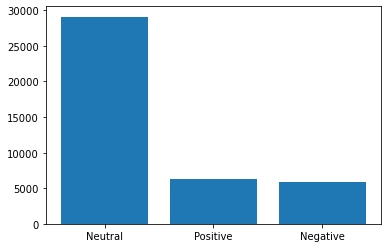

In [15]:
counts = breakingNewsSamp['sentiment'].value_counts()
plt.bar(counts.index, counts.values)
plt.show()

In [17]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2360 sha256=26e5956a2a0fc2e6b35f39815de2e4c7de875ca35f594dd2a7896b4a5a260277
  Stored in directory: /home/hduser/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'sklearn'

In [ ]:

# Load the data
df = pd.read_csv('sentiment_data.csv')

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['sentiment'].values.reshape(-1,1))

# Create a sliding window of data
n_steps = 30
X = []
y = []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i-n_steps:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape the data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the network
model.fit(X_train, y_train, epochs=50, verbose=0)

# Evaluate the network
train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Score: {:.2f} MSE'.format(train_score))
print('Test Score: {:.2f} MSE'.format(test_score))

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse scale the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# Plot the predictions
import matplotlib.pyplot as plt
plt.plot(df['date'][n_steps:train_size], df['sentiment'][n_steps:train_size], label='Training Data')
plt.plot(df['date'][train_size+n_steps:], df['sentiment'][train_size+n_steps:], label='Testing Data')
plt.plot(df['date'][n_steps:train_size], y_train_pred, label='Training Predictions')
plt.plot(df['date'][train_size+n_steps:], y_test_pred, label='Testing Predictions')
plt.legend()
plt.show()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("MongoDBInput") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/college.breakingNews") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/college.breakingNews") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.13:10.1.1") \
    .getOrCreate()

df = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/college.breakingNews") \
    .load()